In [1]:
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import os
import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
import networkx as nx
from features.image_processor import ImageProcessor, FeatureDescriptors, Matcher
from features.track_builder import TrackBuilder
import random
from features.colmap_database_reader import COLMAPExtractor

In [6]:
path_to_images = "dataset/Compressed_buddha"
visualize_tracks = True
max_images = None
verbose = True

camera_matrix = np.array(
    [[1000, 0, 320], [0, 1000, 240], [0, 0, 1]]
)  # Example camera matrix

processor = ImageProcessor(
    path_to_images,
    camera_matrix,
    descriptor_type=FeatureDescriptors.AKAZE,
    matcher_type=Matcher.BRUTE_FORCE,
)

processor.process_all_images(visualize=False)  # Set visualize to True to see matches

In [16]:
# Provide the path to your COLMAP SQLite database file
db_file_path = 'colmap_run/buddha.db'
extractor = COLMAPExtractor(db_file_path)

# Extract keypoints
keypoints = extractor.get_keypoints()
print("Length of keypoints: {}".format(len(keypoints)))

# Extract descriptors
descriptors = extractor.get_descriptors()
print("\nLength of descriptors :: {}".format(len(descriptors)))

# Extract matches
matches = extractor.get_matches()
print("\nLength of matches between images:: {}".format(len(matches)))

images = extractor.get_images()

# Extract two-view geometries
two_view_geometries = extractor.get_two_view_geometries()
print("\nTwo-view geometries between images:")
for pair, geom in two_view_geometries.items():
    # print(f"Pair: {pair}, Fundamental matrix F: {type(geom['F'])}")
    pass

extractor.close()

Length of keypoints: 24

Length of descriptors :: 24

Length of matches between images:: 210

Two-view geometries between images:


In [27]:
keypoints[1]
# matches[(1,2)]

array([[ 9.7636856e+01,  4.9605131e+00],
       [-1.9381682e+00,  2.5435954e-01],
       [-2.5435954e-01, -1.9381682e+00],
       ...,
       [ 5.7338580e+02,  4.5666461e+02],
       [-5.3714672e+01, -9.8535812e+01],
       [ 9.8535812e+01, -5.3714672e+01]], dtype=float32)

In [29]:
# Initialize the TrackBuilder
track_builder = TrackBuilder()

# Add keypoints and descriptors to the TrackBuilder
for image_id, des in descriptors.items():
    kps = keypoints[image_id]
    track_builder.add_keypoints_and_descriptors(image_id, kps, des, True)

# Iterate over all pairs of images to find matches and build tracks
image_ids = list(images.keys())
if max_images is not None:
    image_ids = image_ids[:max_images]


for i in range(len(image_ids)):
    for j in range(i + 1, len(image_ids)):
        img_id1 = image_ids[i]
        img_id2 = image_ids[j]
        if (img_id1, img_id2) in matches:
            matches_for_pair = matches[(img_id1, img_id2)]
            kp_pairs = matches_for_pair.tolist()  # Convert matches to list of tuples
            descriptors1 = descriptors[img_id1]
            descriptors2 = descriptors[img_id2]
            track_builder.add_matches(
                img_id1, img_id2, kp_pairs, descriptors1, descriptors2
            )

In [19]:
# Initialize the TrackBuilder
track_builder = TrackBuilder()

# Add keypoints and descriptors to the TrackBuilder
for image_id, descriptors in processor.descriptors.items():
    keypoints = processor.keypoints[image_id]
    track_builder.add_keypoints_and_descriptors(image_id, keypoints, descriptors)

# Iterate over all pairs of images to find matches and build tracks
image_ids = list(processor.images.keys())
if max_images is not None:
    image_ids = image_ids[:max_images]

for i in range(len(image_ids)):
    for j in range(i + 1, len(image_ids)):
        img_id1 = image_ids[i]
        img_id2 = image_ids[j]
        if (img_id1, img_id2) in processor.matches:
            matches = processor.matches[(img_id1, img_id2)]
            kp_pairs = [(m.queryIdx, m.trainIdx) for m in matches]
            descriptors1 = processor.descriptors[img_id1]
            descriptors2 = processor.descriptors[img_id2]
            track_builder.add_matches(
                img_id1, img_id2, kp_pairs, descriptors1, descriptors2
            )

In [30]:
G = track_builder.graph
connected_components = list(nx.connected_components(G))
print(len(connected_components))

106280


In [31]:
tracks = track_builder.extract_tracks()
if verbose:
    print(f"Extraced tracks list :: {len(tracks)}")
track_builder.save_tracks_to_hdf5(
    tracks, filename="features/data/tracks_compressed_buddha.hdf5"
)

Extraced tracks list :: 121683


TypeError: Can't implicitly convert non-string objects to strings

In [22]:
filename = "features/data/tracks_compressed_buddha.hdf5"
loaded_tracks = TrackBuilder.load_tracks_from_hdf5(filename)
print(f"Loaded {len(loaded_tracks)} tracks from the file.")

Loaded 10491 tracks from the file.


Length of valid tracks :: 7128


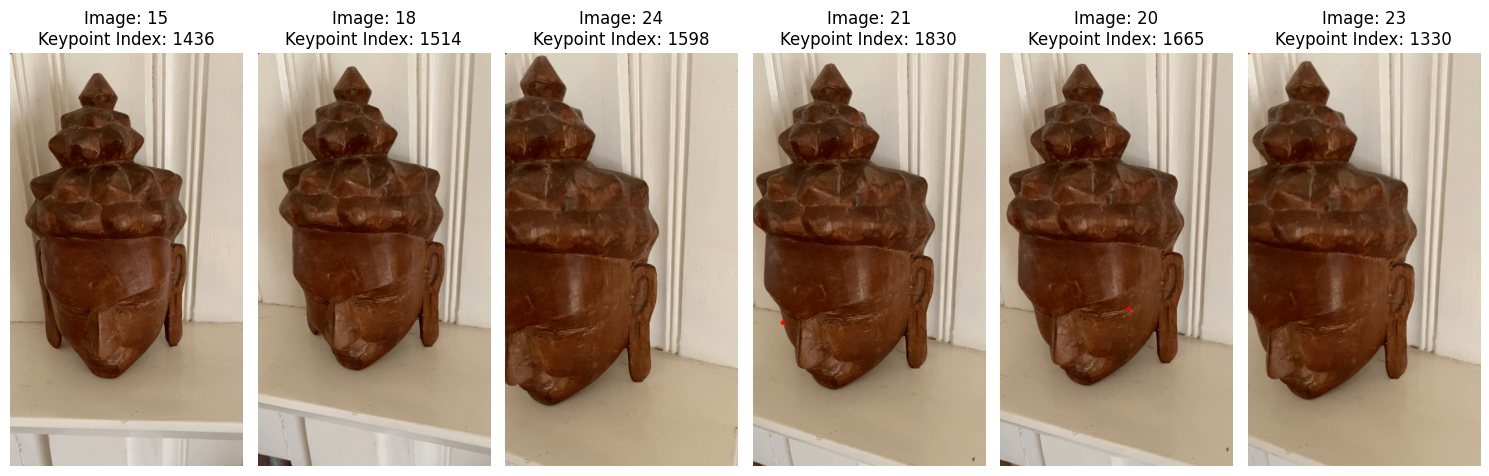

In [38]:
valid_tracks = [track for track in tracks if len(track) >= 3]
print(f"Length of valid tracks :: {len(valid_tracks)}")
if not valid_tracks:
    print("No tracks with at least 4 keypoints found.")
else:
    selected_track = random.choice(valid_tracks)
    num_images = len(selected_track)

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    if num_images == 1:
        axes = [axes]  # Make it iterable

    for idx, node in enumerate(selected_track):
        image_id, kp_index = node
        image_path = os.path.join(
            processor.folder_path, f"{images[image_id]['name']}.png"
        )  # Ensure the file extension is correct
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        kp = keypoints[image_id][kp_index]

        # Draw the keypoint
        cv2.circle(image, (int(kp[0]), int(kp[1])), 5, (255, 0, 0), 10)

        # Display the image
        ax = axes[idx]
        ax.imshow(image)
        ax.set_title(f"Image: {image_id}\nKeypoint Index: {kp_index}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()